In [486]:
import os
import sys

import pandas as pd
import numpy as np

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as T
from torchsummary import summary
import torch.nn.functional as F
# MAKE SURE TO SHUFFLE IMPORT ORDER AND DELETE USELESS IMPORTS
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, Dropout, BatchNorm2d, BCELoss
from torch.optim import Adam, SGD

In [421]:
# Data Directories
maskdir = "F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masknomask\dataset\dataset\with_mask"
nomaskdir = "F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masknomask\dataset\dataset\without_mask"

In [422]:
def rename_images(im_dir, prefix="", suffix=""):
    """
    Utility function that renames all the images in a folder to have increasing integer numbers.
    """
    
    if not os.path.isdir(im_dir):
        print("The specified directory '{}' does not exist.")
        return False
    
    for i, fname in enumerate(os.listdir(im_dir)):
        _, ext = os.path.splitext(fname)
        new_name = prefix + str(i) + suffix + ext
        
        try:
            os.rename(os.path.join(im_dir,fname), os.path.join(im_dir,new_name))
        except FileExistsError:
            continue
            
    return True

In [423]:
# - rename images in mask set
rename_images("F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masknomask\dataset\dataset\with_mask",
             suffix="_m")

# - rename images in no mask set
rename_images("F:\Libraries\Documents\ALL\School\GrDip\comp6721_applied_artificial_intelligence\project\FaceMaskCNN\data\masknomask\dataset\dataset\without_mask",
             suffix="_nm")

True

### Dataset Creation and Preparation

In [437]:
# Define image transforms
preprocess = T.Compose([
    T.ToTensor(),
    T.Resize([32,32])
])

In [447]:
#
# Import Data #
#

# Create the labeled data indices
df1 = pd.DataFrame(os.listdir(maskdir)).rename({0:"file_id"}, axis=1)
df1["label_literal"] = os.path.split(maskdir)[1]

df2 = pd.DataFrame(os.listdir(nomaskdir)).rename({0:"file_id"}, axis=1)
df2["label_literal"] = os.path.split(nomaskdir)[1]


data = pd.concat([df1, df2])
data = data.reset_index(drop=True)
data["label"] = data["label_literal"].apply(lambda x : 0 if x=="without_mask" else 1)

# Load the images
labels = data["label"].to_numpy()
images = []
for row in data.itertuples():
    
    if row.label_literal == "with_mask":
        im_path = os.path.join(maskdir, row.file_id)
    elif row.label_literal == "without_mask":
        im_path = os.path.join(nomaskdir, row.file_id)
        
    image = imread(im_path, as_gray=True)
    
    # Normalize image so that it is between 0 and 1
    image = image/255.0
    
    # Change data to float32 (dont think this is necessary? Might help speed up processing)
    image = image.astype("float32")
    
    # Apply Torch transforms
    image = preprocess(image)
    
    images.append(image)

    
#images = np.array(images)
image_tensor = torch.cat(images)

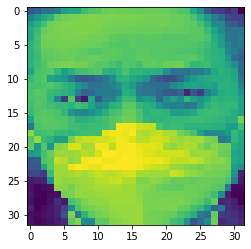

In [448]:
plt.imshow(image_tensor[121])

In [451]:
# Split the data into train and test
labels = torch.tensor(labels)
X_train, X_test, y_train, y_test = train_test_split(image_tensor, labels, test_size=0.3, stratify=labels, random_state=43)

In [452]:
# Add the channel dimension to the train and test sets
X_train = torch.unsqueeze(X_train, 1)
X_test = torch.unsqueeze(X_test, 1)

In [453]:
print(X_train.shape)
print(X_test.shape)

torch.Size([2682, 1, 32, 32])
torch.Size([1150, 1, 32, 32])


In [430]:
# Create dataset class

# class MaskNoMaskDset(Dataset):
    

In [534]:
# Define CNN

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.5),
            
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 8 * 8, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        

In [535]:
devnet = Net()
summary(devnet, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]              40
       BatchNorm2d-2            [-1, 4, 32, 32]               8
              ReLU-3            [-1, 4, 32, 32]               0
         MaxPool2d-4            [-1, 4, 16, 16]               0
           Dropout-5            [-1, 4, 16, 16]               0
            Conv2d-6            [-1, 4, 16, 16]             148
       BatchNorm2d-7            [-1, 4, 16, 16]               8
              ReLU-8            [-1, 4, 16, 16]               0
         MaxPool2d-9              [-1, 4, 8, 8]               0
           Linear-10                    [-1, 2]             514
Total params: 718
Trainable params: 718
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Siz

In [536]:
# Defining optimizers and loss function

testmodel = Net()
adam_opt = Adam(testmodel.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

In [537]:
y_train

tensor([0, 1, 1,  ..., 0, 0, 0])

In [538]:
output_train

tensor([[ 0.6557, -0.2302],
        [-0.1317,  1.5396],
        [-1.1518,  2.7985],
        ...,
        [-0.5567,  1.2203],
        [ 0.8210, -0.5283],
        [ 1.4116,  0.2917]], grad_fn=<AddmmBackward0>)

In [539]:
# Training Loop


# torch.set_grad_enabled(True)
num_epochs = 50
train_losses = []
tr_loss = 0
testmodel.train()
for epoch in range(num_epochs):
    
    train_loss = 0
    
    adam_opt.zero_grad()
    
    output_train = testmodel(X_train)
    
    loss_train = criterion(output_train, y_train)
    train_losses.append(loss_train)
    
    loss_train.backward()
    adam_opt.step()
    
    if epoch%2 == 0:
        print("Epoch: {}      Loss: {}".format(epoch, loss_train))

Epoch: 0      Loss: 0.719201385974884
Epoch: 2      Loss: 0.7096483707427979
Epoch: 4      Loss: 0.7002910375595093
Epoch: 6      Loss: 0.6890263557434082
Epoch: 8      Loss: 0.6776925921440125
Epoch: 10      Loss: 0.6627748608589172
Epoch: 12      Loss: 0.6536746621131897
Epoch: 14      Loss: 0.6398228406906128
Epoch: 16      Loss: 0.634195864200592
Epoch: 18      Loss: 0.6208580732345581
Epoch: 20      Loss: 0.6182875633239746
Epoch: 22      Loss: 0.6018685698509216
Epoch: 24      Loss: 0.5948046445846558
Epoch: 26      Loss: 0.5804978013038635
Epoch: 28      Loss: 0.5682235956192017
Epoch: 30      Loss: 0.5604888796806335
Epoch: 32      Loss: 0.5509119033813477
Epoch: 34      Loss: 0.5408916473388672
Epoch: 36      Loss: 0.5340945720672607
Epoch: 38      Loss: 0.5213881134986877
Epoch: 40      Loss: 0.5196241140365601
Epoch: 42      Loss: 0.5116056203842163
Epoch: 44      Loss: 0.5114365220069885
Epoch: 46      Loss: 0.5050814747810364
Epoch: 48      Loss: 0.4888530969619751


In [540]:
with torch.no_grad():
    test_out = testmodel(X_test)

softmax = torch.exp(test_out)
prob = list(softmax.numpy())
preds = np.argmax(prob, axis=1)

In [541]:
accuracy_score(y_test, preds)

0.7669565217391304